# Задача
В этой работе вам предлагается решить задачу бинарной классификации, а именно построить алгоритм, определяющий превысит ли средний заработок человека порог $50k. Каждый объект выборки — человек, для которого известны следующие признаки:
 - age
 - workclass
 - fnlwgt
 - education
 - education-num
 - marital-status
 - occupation
 - relationship
 - race
 - sex
 - capital-gain
 - capital-loss
 - hours-per-week
 
Более подробно про признаки можно почитать [здесь](http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names). Целевой признак записан в переменной *>50K,<=50K*.

В этой задаче для обучения будут использовать 2 алгоритма:
 - [DecisonTree](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)
 - [RandomForest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [94]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import cross_val_score
from scipy.stats import mode
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, classification_report

# Решение

Загрузите набор данных *data.adult.csv* с помощью `pandas` (скачать можно [здесь](https://drive.google.com/file/d/1Lo47fXx1RrJG3v9E-Gck1T45n5bJ_SJf/view?usp=sharing), или с помощью скрипта ниже). Чтобы лучше понимать, с чем вы работаете/корректно ли вы загрузили данные можно вывести несколько первых строк на экран.

In [1]:
!gdown 1Lo47fXx1RrJG3v9E-Gck1T45n5bJ_SJf

Downloading...
From: https://drive.google.com/uc?id=1Lo47fXx1RrJG3v9E-Gck1T45n5bJ_SJf
To: /home/evgeniy/jupyter/data.adult.csv
100%|██████████████████████████████████████| 1.54M/1.54M [00:00<00:00, 2.19MB/s]


In [3]:
df = pd.read_csv('data.adult.csv')

In [4]:
df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,<=50K
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,<=50K
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40,<=50K
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,<=50K
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40,>50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16275,25,Local-gov,514716,Bachelors,13,Never-married,Adm-clerical,Own-child,Black,Female,0,0,40,<=50K
16276,32,Private,207668,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,15024,0,45,>50K
16277,27,Private,104457,Bachelors,13,Never-married,Machine-op-inspct,Not-in-family,Asian-Pac-Islander,Male,0,0,40,<=50K
16278,59,State-gov,268700,HS-grad,9,Married-civ-spouse,Other-service,Husband,White,Male,0,0,40,<=50K


## Анализ и предобработка данных

Обычно после загрузки датасета всегда необходима его некоторая предобработка. В данном случае она будет заключаться в следующем: 
1. Проверьте есть ли в данных пропущенные значения (здесь они обозначены как "?"). Удалите из выборки все объекты с пропусками.
2. Выделите 60% выборки для обучения и дальнейшего анализа.
3. Обратите внимание, что не все признаки являются вещественными (числовыми). Сначала их необходимо проанализировать и по необходимости предобработать. Все шаги предобработки поясните текстом.
4. Целевую переменную (ту, которую мы хотим предсказывать) можно выделить в отдельную переменную и преобразуйте к бинарному формату (НЕ забудьте удалить ее из датасета, когда будете обучать модель).


Удалим пропущенные значения:

In [5]:
df.replace("?", pd.NA, inplace=True)
df.dropna(inplace=True)

Выделим целевой признак:

In [44]:
X = df.drop(columns = ">50K,<=50K")
y = (df['>50K,<=50K'] == '>50K').astype(int)

In [45]:
categorical_columns = X.select_dtypes(include=["object"]).columns.tolist()
numerical_columns = X.select_dtypes(include=["number"]).columns.tolist()

Отметим, что признак fnlwgt является комплесной оценкой гражданского населения, имеет большой разброс и может негативно влиять на модель, потому что не известно, несет ли он полезную информацию. Исключим его.

In [46]:
X.drop(columns= "fnlwgt", inplace=True)

При обучении алгоритмов стоит обращать внимание не только на их качество, но и каким образом они работают с данными. Давайте посмотрим на значения самих признаков.

Что можете сказать о разбросе данных и сбалансированности выборки? В каком диапазоне лежат исследуемые признаки?

In [47]:
X.describe()

,age,education-num,capital-gain,capital-loss,hours-per-week
count,15347.000000,15347.000000,15347.000000,15347.000000,15347.000000
mean,38.495537,10.150844,1053.294129,88.667492,40.892422
std,13.110063,2.553045,7001.715695,405.368093,12.031182
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,47.000000,13.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,3900.000000,99.000000


Столбцы capital-gain и capital-loss имеют много нулей и значительные выбросы. Введем бинарный признак наличия или отсутствия capital-gain и capital-loss. Для того чтобы сохранить информацию о распределении capital-gain и capital-loss логарифмируем исходные величины, уменьшив дисперсию.

In [48]:
X["has_capital_gain"] = (X["capital-gain"] > 0).astype(int)
X["has_capital_loss"] = (X["capital-loss"] > 0).astype(int)

X["log_capital_gain"] = np.log1p(X["capital-gain"])
X["log_capital_loss"] = np.log1p(X["capital-loss"])

X.drop(columns=["capital-gain", "capital-loss"], inplace=True)

Отдельно вызывает вопросы столбец hours-per-week, если количество часов больше 60 еще возможно, то больше 80 выглядит нереалистично. 

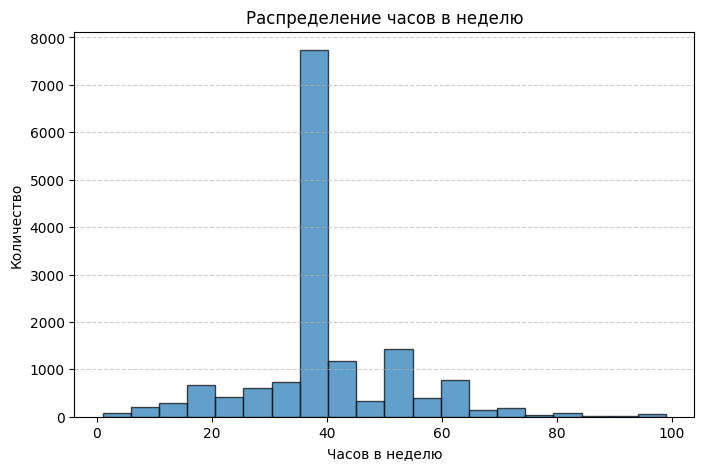

In [49]:
plt.figure(figsize=(8, 5))
plt.hist(df["hours-per-week"], bins=20, edgecolor="black", alpha=0.7)
plt.xlabel("Часов в неделю")
plt.ylabel("Количество")
plt.title("Распределение часов в неделю")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


Посмотрим на межквантильный размах:

In [50]:
Q1 = X["hours-per-week"].quantile(0.25)
Q3 = X["hours-per-week"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR  # Нижняя граница
upper_bound = Q3 + 1.5 * IQR  # Верхняя граница

print(f"\nВерхняя граница: {upper_bound}, нижняя граница: {lower_bound}")


Верхняя граница: 52.5, нижняя граница: 32.5


Значений, которые больше верхней границы достаточно много, к тому же высокие значения могут быть объяснены спецификой работы, например предпринимателей. Поэтому обрежем совсем большие значения >80, остаив всё остальное как есть.

In [51]:
X["hours-per-week"] = X["hours-per-week"].clip(upper=80)

In [52]:
X.describe()

,age,education-num,hours-per-week,has_capital_gain,has_capital_loss,log_capital_gain,log_capital_loss
count,15347.000000,15347.000000,15347.000000,15347.000000,15347.000000,15347.000000,15347.000000
mean,38.495537,10.150844,40.806672,0.086532,0.047501,0.763777,0.356478
std,13.110063,2.553045,11.689060,0.281157,0.212715,2.497239,1.597430
min,17.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,9.000000,40.000000,0.000000,0.000000,0.000000,0.000000
50%,37.000000,10.000000,40.000000,0.000000,0.000000,0.000000,0.000000
75%,47.000000,13.000000,45.000000,0.000000,0.000000,0.000000,0.000000
max,90.000000,16.000000,80.000000,1.000000,1.000000,11.512925,8.268988


In [53]:
X

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,hours-per-week,has_capital_gain,has_capital_loss,log_capital_gain,log_capital_loss
0,34,Local-gov,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,60,1,0,6.388561,0.000000
1,40,Private,Some-college,10,Divorced,Sales,Not-in-family,White,Male,40,0,0,0.000000,0.000000
2,36,Local-gov,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,40,0,0,0.000000,0.000000
3,22,Private,Some-college,10,Never-married,Sales,Own-child,White,Female,30,0,0,0.000000,0.000000
4,47,Private,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,40,1,0,9.617471,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16275,25,Local-gov,Bachelors,13,Never-married,Adm-clerical,Own-child,Black,Female,40,0,0,0.000000,0.000000
16276,32,Private,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,45,1,0,9.617471,0.000000
16277,27,Private,Bachelors,13,Never-married,Machine-op-inspct,Not-in-family,Asian-Pac-Islander,Male,40,0,0,0.000000,0.000000
16278,59,State-gov,HS-grad,9,Married-civ-spouse,Other-service,Husband,White,Male,40,0,0,0.000000,0.000000


## Добавление категориальных признаков

Добавим к предобработанным вещественным признакам категориальные. Но для начала их тоже необходимо предобработать.

Преобразуйте все категориальные признаки с помощью метода one-hot-encoding (например, это можно сделать с помощью функции [pandas.get_dummies](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) или [DictVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html) / [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) из sklearn).

После преобразования категориальных признаков, добавьте их к вещественным предобработанным данным для обучения.

>PS Напоминаю, что важно удалить колонку с целевым значением

In [54]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
encoded_array = encoder.fit_transform(X[categorical_columns])
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(categorical_columns))
X = X.drop(columns=categorical_columns).reset_index(drop=True)
X = pd.concat([X, encoded_df], axis=1)

In [55]:
X

,age,education-num,hours-per-week,has_capital_gain,has_capital_loss,log_capital_gain,log_capital_loss,workclass_Federal-gov,workclass_Local-gov,workclass_Private,...,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male
0,34,9,60,1,0,6.388561,0.000000,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,40,10,40,0,0,0.000000,0.000000,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,36,13,40,0,0,0.000000,0.000000,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,22,10,30,0,0,0.000000,0.000000,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,47,13,40,1,0,9.617471,0.000000,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15342,25,13,40,0,0,0.000000,0.000000,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
15343,32,13,45,1,0,9.617471,0.000000,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
15344,27,13,40,0,0,0.000000,0.000000,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
15345,59,9,40,0,0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


Разделим выборку на обучение и валидацию:

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

## Обучение классификаторов

В начале посмотрим, как работает подбор параметров по сетке и как влияет на качество разбиение выборки. Сейчас и далее будем рассматривать 2 алгоритма:
 - [DecisonTree](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)
 - [RandomForest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

Для начала обучим  выберем один гиперпараметр, который будем оптимизировать, — глубина дерева (*max_depth*).
 
Остальные параметры оставляйте в значениях по умолчанию.

Для каждого алгоритма подберите оптимальные значения указанных гиперпараметров. Постройте график среднего значения качества по кросс-валидации алгоритма при заданном значении гиперпараметра, на котором также отобразите доверительный интервал.

Что вы можете сказать о получившихся графиках? Какой алгоритм справился лучше? Какой быстрее? Почему?

Decision Tree: Лучший CV Accuracy = 0.846 при max_depth = 6
Random Forest: Лучший CV Accuracy = 0.852 при max_depth = 10
Среднее время CV для Decision Tree: 0.09 сек
Среднее время CV для Random Forest: 1.39 сек


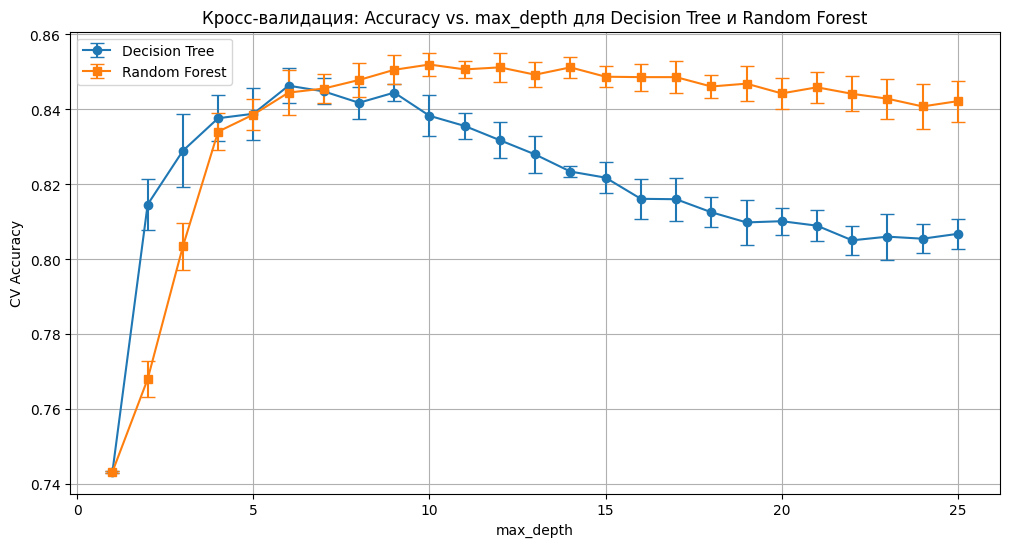

In [57]:
depths = range(1, 26)

dt_scores_mean = []
dt_scores_std = []
dt_cv_times = []

rf_scores_mean = []
rf_scores_std = []
rf_cv_times = []

for depth in depths:
    dt_model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    start_time = time.time()
    dt_scores = cross_val_score(dt_model, X_train, y_train, cv=5, scoring='accuracy')
    dt_time = time.time() - start_time
    dt_cv_times.append(dt_time)
    dt_scores_mean.append(np.mean(dt_scores))
    dt_scores_std.append(np.std(dt_scores))
    
    rf_model = RandomForestClassifier(max_depth=depth, random_state=42)
    start_time = time.time()
    rf_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy')
    rf_time = time.time() - start_time
    rf_cv_times.append(rf_time)
    rf_scores_mean.append(np.mean(rf_scores))
    rf_scores_std.append(np.std(rf_scores))
    
best_dt_index = np.argmax(dt_scores_mean)
best_dt_depth = depths[best_dt_index]
best_dt_score = dt_scores_mean[best_dt_index]

best_rf_index = np.argmax(rf_scores_mean)
best_rf_depth = depths[best_rf_index]
best_rf_score = rf_scores_mean[best_rf_index]

print(f"Decision Tree: Лучший CV Accuracy = {best_dt_score:.3f} при max_depth = {best_dt_depth}")
print(f"Random Forest: Лучший CV Accuracy = {best_rf_score:.3f} при max_depth = {best_rf_depth}")

avg_dt_time = np.mean(dt_cv_times)
avg_rf_time = np.mean(rf_cv_times)
print(f"Среднее время CV для Decision Tree: {avg_dt_time:.2f} сек")
print(f"Среднее время CV для Random Forest: {avg_rf_time:.2f} сек")

plt.figure(figsize=(12, 6))
plt.errorbar(depths, dt_scores_mean, yerr=dt_scores_std, label='Decision Tree',
             marker='o', capsize=5)
plt.errorbar(depths, rf_scores_mean, yerr=rf_scores_std, label='Random Forest',
             marker='s', capsize=5)
plt.xlabel('max_depth')
plt.ylabel('CV Accuracy')
plt.title('Кросс-валидация: Accuracy vs. max_depth для Decision Tree и Random Forest')
plt.legend()
plt.grid(True)
plt.show()

**Ответ:** В начале обе модели ведут себя похожим образом, однако после примерно max_depth = 7 точность decision tree начинает снижаться за счет переобучения. Точность random forest при этом продолжает расти, а затем стабилизируется, потому что случайный лес устойчив к переобучению за счет обучения многих деревьев и использования их взвешенных оценок. При этом разница в точности не превышеает 0.01, тогда как разница во времени значительна: обучение случайного леса почти в 15 раз дольше, по тем же причинам, нам необходимо обучать много деревьев, а не одно.

Далее произведем подбор других гиперпараметров алгоритмов. Начнем со случайного леса. Для начала подберём число деревьев (*n_estimators*) в алгоритме RandomForest. Как известно, в общем случае Random Forest не переобучается с увеличением количества деревьев. Подберите количество деревьев, начиная с которого качество на кросс-валидации стабилизируется. Обратите внимание, что для проведения этого эксперимента не нужно с нуля обучать много случайных лесов с различными количествами деревьев. Обучите один случайный лес с максимальным интересным количеством деревьев, а затем рассмотрите подмножества деревьев разных размеров, состоящих из деревьев построенного леса (поле [*estimators_*](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)). В дальнейших экспериментах используйте подобранное количество деревьев.

n_estimators = 5, средняя точность = 0.962
n_estimators = 10, средняя точность = 0.971
n_estimators = 15, средняя точность = 0.979
n_estimators = 20, средняя точность = 0.980
n_estimators = 25, средняя точность = 0.982
n_estimators = 30, средняя точность = 0.982
n_estimators = 35, средняя точность = 0.983
n_estimators = 40, средняя точность = 0.983
n_estimators = 45, средняя точность = 0.983
n_estimators = 50, средняя точность = 0.983
n_estimators = 55, средняя точность = 0.984
n_estimators = 60, средняя точность = 0.984
n_estimators = 65, средняя точность = 0.984
n_estimators = 70, средняя точность = 0.984
n_estimators = 75, средняя точность = 0.984
n_estimators = 80, средняя точность = 0.985
n_estimators = 85, средняя точность = 0.984
n_estimators = 90, средняя точность = 0.985
n_estimators = 95, средняя точность = 0.984
n_estimators = 100, средняя точность = 0.985
n_estimators = 105, средняя точность = 0.985
n_estimators = 110, средняя точность = 0.985
n_estimators = 115, средняя то

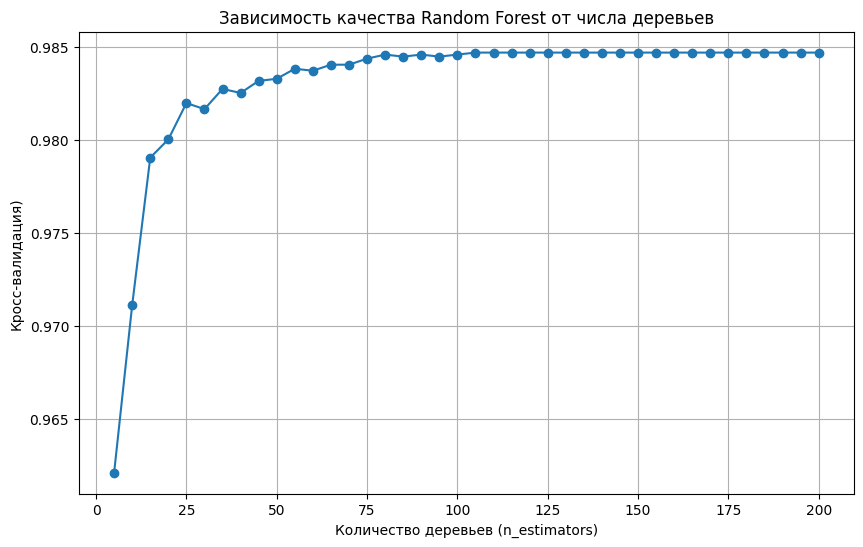

In [68]:
max_estimators = 200 
subset_sizes = range(5, max_estimators + 1, 5)
n_folds = 5  

rf_model = RandomForestClassifier(n_estimators=max_estimators, random_state=42)
rf_model.fit(X_train, y_train)

kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
accuracy_scores = []

for n in subset_sizes:
    fold_accuracies = []
    for train_idx, test_idx in kf.split(X_train):
        X_fold_test = X_train.iloc[test_idx]  
        y_fold_test = y_train.iloc[test_idx] 
        
        preds = np.array([estimator.predict(X_fold_test.values) for estimator in rf_model.estimators_[:n]])
        y_pred, _ = mode(preds, axis=0) 
        y_pred = y_pred.ravel()
        
        acc = accuracy_score(y_fold_test, y_pred)
        fold_accuracies.append(acc)
    
    mean_acc = np.mean(fold_accuracies)
    accuracy_scores.append(mean_acc)
    print(f"n_estimators = {n}, средняя точность = {mean_acc:.3f}")

plt.figure(figsize=(10, 6))
plt.plot(list(subset_sizes), accuracy_scores, marker='o')
plt.xlabel('Количество деревьев (n_estimators)')
plt.ylabel('Кросс-валидация)')
plt.title('Зависимость качества Random Forest от числа деревьев')
plt.grid(True)
plt.show()

**Ответ:** Качество стабилизируется при n_estimators >=80. Будем использовать это значение в качестве значения гиперпараметра.

Теперь подберите следующие оптимальные параметры:
- максимальная глубина решающего дерева (*max_depth*)
- функция оценки качества разбиения (*criterion*)
- максимальное количесво учитываемых признаков при разбиении (*max_features*)

Остальные параметры оставляйте по умолчанию, за исключением парамтра `n_estimators` для случайного леса, выбранного на предыдущем шаге.



In [82]:
tree_times = []
forest_times = []

In [84]:
n_estimators = 80  

max_depth_options = range(5, 15)
criterion_options = ['gini', 'entropy', 'log_loss']
max_features_options = ['sqrt', 'log2', None]

best_params = {}
best_accuracy = 0

for max_depth in max_depth_options:
    for criterion in criterion_options:
        for max_features in max_features_options:
            start_time = time.time()
            rf_model = RandomForestClassifier(
                n_estimators=n_estimators,
                max_depth=max_depth,
                criterion=criterion,
                max_features=max_features,
                random_state=42
            )
            rf_model.fit(X_fold_train, y_fold_train)      
            end_time = time.time()
            forest_times.append(end_time - start_time)
            
            scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy')
            mean_accuracy = np.mean(scores)  
            
            if mean_accuracy > best_accuracy:
                best_accuracy = mean_accuracy
                best_params = {
                    'max_depth': max_depth,
                    'criterion': criterion,
                    'max_features': max_features
                }

print("Лучшие параметры:", best_params)
print(f"Лучшая точность: {best_accuracy:.4f}")

Лучшие параметры: {'max_depth': 11, 'criterion': 'entropy', 'max_features': None}
Лучшая точность: 0.8518


Теперь рассмотрим decision tree:

In [85]:
max_depth_options = range(5, 12)
criterion_options = ['gini', 'entropy', 'log_loss']
max_features_options = ['sqrt', 'log2', None]

n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

best_score = 0
best_params = {}

for max_depth in max_depth_options:
    for criterion in criterion_options:
        for max_features in max_features_options:
            fold_accuracies = []  
            for train_idx, test_idx in kf.split(X_train):
                X_fold_train = X_train.iloc[train_idx]
                X_fold_test = X_train.iloc[test_idx]
                y_fold_train = y_train.iloc[train_idx]
                y_fold_test = y_train.iloc[test_idx]
                start_time = time.time()
                tree_model = DecisionTreeClassifier(
                    max_depth=max_depth,
                    criterion=criterion,
                    max_features=max_features,
                    random_state=42
                )
                tree_model.fit(X_fold_train, y_fold_train)
                end_time = time.time()
                tree_times.append(end_time - start_time) 
                
                y_pred = tree_model.predict(X_fold_test)
                acc = accuracy_score(y_fold_test, y_pred)
                fold_accuracies.append(acc)
            
            mean_acc = np.mean(fold_accuracies)
            
            if mean_acc > best_score:
                best_score = mean_acc
                best_params = {
                    'max_depth': max_depth,
                    'criterion': criterion,
                    'max_features': max_features
                }

print("Лучшие параметры:", best_params)
print(f"Лучшая точность: {best_accuracy:.4f}")

Лучшие параметры: {'max_depth': 7, 'criterion': 'gini', 'max_features': None}
Лучшая точность: 0.8518


Оцените скорость обучения каждого из алгоритмов. Для этого воспользуйтесь графиком вида "ящик с усами", который отражает среднее время обучения алгоритма при фиксированном значении гиперпараметров. Что вы можете сказать о скорости работы алгоритмов? Почему наблюдаются такие результаты? Можно ли ускорить? Если да, то каким образом?

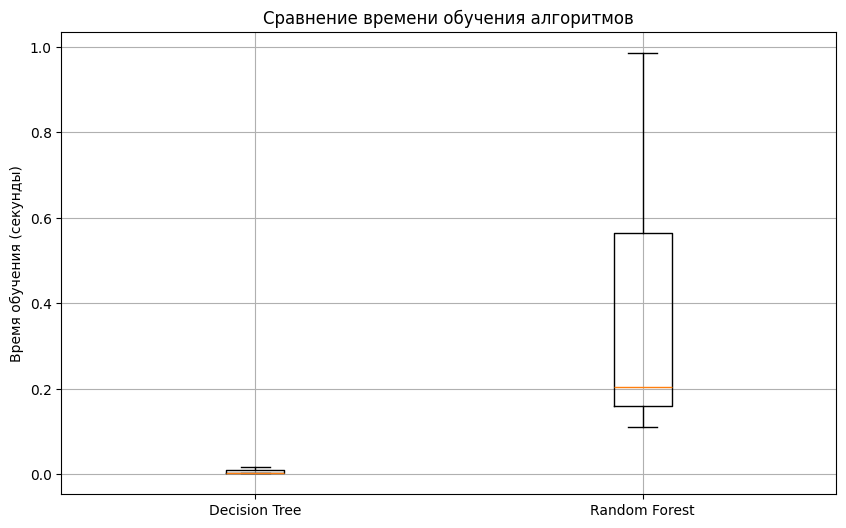

In [91]:
plt.figure(figsize=(10, 6))
plt.boxplot([tree_times, forest_times], tick_labels=['Decision Tree', 'Random Forest'])
plt.ylabel('Время обучения (секунды)')
plt.title('Сравнение времени обучения алгоритмов')
plt.grid(True)
plt.show()

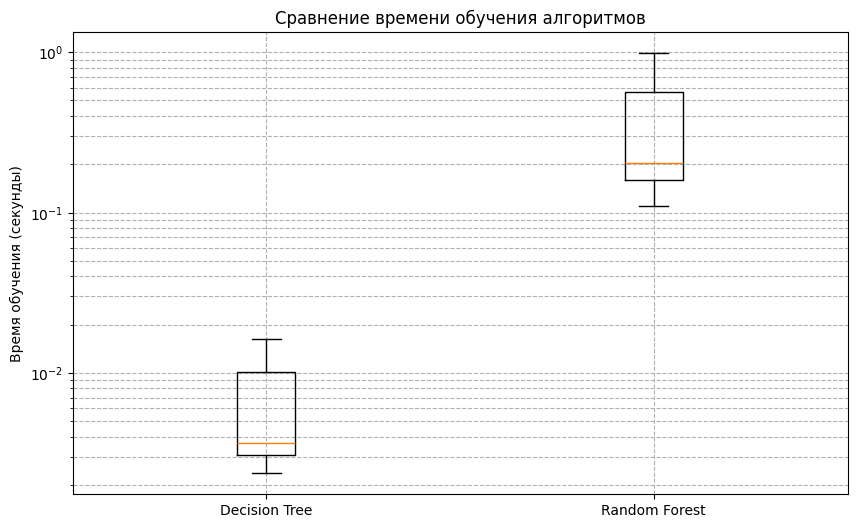

In [89]:
plt.figure(figsize=(10, 6))
plt.boxplot([tree_times, forest_times], tick_labels=['Decision Tree', 'Random Forest'])  
plt.yscale('log')  
plt.ylabel('Время обучения (секунды)')
plt.title('Сравнение времени обучения алгоритмов')
plt.grid(True, which="both", linestyle="--")  
plt.show()

**Ответ:** Для обучения решающего дерева требуются доли секунды. Увеличить скорость его обучения можно ограничив параметры max_depth и max_feautures. Случайный лес обучается кратно дольше, что естественным образом связано с тем, что в данной модели обучается множество деревьев (в нашем случае 80). Скорость обучения случайного леса можно уменьшить значительно ограничив число деревьев, и немного можно влиять на скорость обучния варьируя max_depth и max_features. При этом важно отметить, что количество деревьев играет ключевую роль в устойчивости модели к переобучению. 
Также важно заметить, что в обоих моделях наилучшим значением max_features получился None. То есть обе модели используют все признаки для обучения, что повышает точность и увеличивает время обучения, но вполне вероятно, что у нас есть скореллированные признаки и их можно удалить, незначительно потеряв в точности. Также использование всех признаков может давать переобучение.

## Сравнение результатов

Сравните результаты алгоритмов. Для этого воспользуйтесь "ящиком с усами" (boxplot).

Сделайте общие итоговые выводы о классификаторах с точки зрения их работы с признаками и сложности самой модели (какие гиперпараметры есть у модели, сильно ли изменение значения гиперпараметра влияет на качество модели).

**Ответ:** Решающее дерево склонно к переобучению, если дерево становится слишком глубоким. Если глубина слишком большая, то модель переобучается, если слишком маленькая недообучается. У этой модели понятная для анализа структура и высокая скорость обучения.

Случайный лес – это ансамбль деревьев, что делает его устойчивее к выбросам и шуму в данных. Он лучше обобщает информацию, но сложнее в анализе, так как состоит из множества деревьев. Эта модель более стабильная. Она дольше обучается, но обычно показывает лучшие результаты, особенно на больших наборах данных. На случайный лес сильно влияет количество деревьев - оно увеличивает точность и стабильность, но сильно влияет на время обучения.

## Тестирование всех моделей

Протестируйте последние построенные модели (наилучшее решающее дерево и наилучший случайный лес) на данных, которые были отложены для теста (их должно было остаться 40%). Не забудьте про все необходимые преобразования.

In [95]:
best_tree = DecisionTreeClassifier(
                    max_depth=7,
                    criterion='gini',
                    max_features=None,
                    random_state=42
                )
best_tree.fit(X_train, y_train)

y_pred_tree = best_tree.predict(X_test)
accuracy_tree = accuracy_score(y_test, y_pred_tree)
print("Decision Tree Accuracy:", accuracy_tree)
print("Decision Tree Classification Report:\n", classification_report(y_test, y_pred_tree))

best_forest = RandomForestClassifier(
                n_estimators=80,
                max_depth=11,
                criterion='entropy',
                max_features=None,
                random_state=42
            )
best_forest.fit(X_train, y_train)

y_pred_forest = best_forest.predict(X_test)
accuracy_forest = accuracy_score(y_test, y_pred_forest)
print("Random Forest Accuracy:", accuracy_forest)
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_forest))

Decision Tree Accuracy: 0.8454145626323506
Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.93      0.90      4563
           1       0.76      0.59      0.66      1576

    accuracy                           0.85      6139
   macro avg       0.81      0.76      0.78      6139
weighted avg       0.84      0.85      0.84      6139

Random Forest Accuracy: 0.8514416028669164
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.94      0.90      4563
           1       0.77      0.60      0.68      1576

    accuracy                           0.85      6139
   macro avg       0.82      0.77      0.79      6139
weighted avg       0.85      0.85      0.85      6139



**Ответ:** Случайный лес показывает немного большую точность по сравнению с решающим деревом в данном случае. При этом обе модели дают лучшие precision и recall для 0 класса (доход меньше 50 к долларов). Дисбаланс классов в данном случае обусловлен естественными причинами. Возможно ограничение числа используемых признаков моделью может повысить точность обоих моделей на тестовой выборки, так как использование всех признаков вызывает переобучение. 